In [1]:
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

1. Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [2]:
credit = pd.read_csv('credit_card_default_analysis.csv')
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [33]:
credit.shape

(30000, 25)

In [3]:
repayment = credit[credit.default == 0]
loan = credit[credit.default == 1]

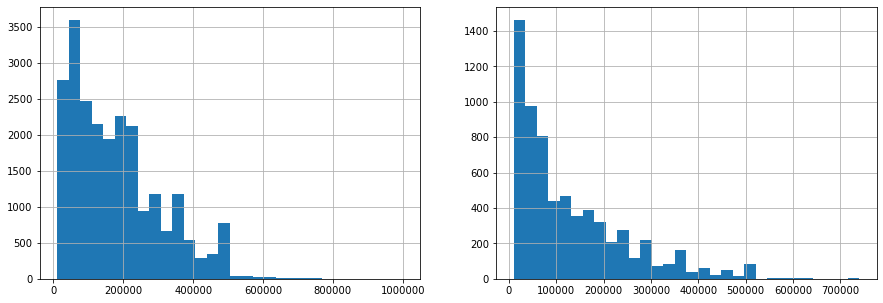

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
repayment.LIMIT_BAL.hist(bins=30)
plt.subplot(1,2,2)
loan.LIMIT_BAL.hist(bins=30)

In [5]:
print('Median LIMIT_BAL for default = 0: %.0f' % repayment.LIMIT_BAL.median())
print('Median LIMIT_BAL for default = 1: %.0f' % loan.LIMIT_BAL.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


Бутстрэп

In [6]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [7]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [8]:
np.random.seed(123)

repayments_median = np.median(get_bootstrap_samples(repayment.LIMIT_BAL.values, 1000), axis=1)
loans_median = np.median(get_bootstrap_samples(loan.LIMIT_BAL.values, 1000), axis=1)

print("95% confidence interval for good clients:",  stat_intervals(repayments_median))
print("95% confidence interval for default clients:",  stat_intervals(loans_median))

95% confidence interval for good clients: [150000. 150000.]
95% confidence interval for default clients: [80000. 90000.]


In [9]:
delta_median = list(map(lambda x: x[1] - x[0], zip(loans_median, repayments_median)))

In [10]:
print("95% confidence interval for difference median:",  stat_intervals(delta_median, 0.05))

95% confidence interval for difference median: [60000. 70000.]


Перестановочный критерий

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [12]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [13]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [14]:
def permutation_test(sample1, sample2, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample1, sample2)
    
    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [15]:
permutation_test(repayment.LIMIT_BAL.values, loan.LIMIT_BAL.values, max_permutations=10000)

0.0001

Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [16]:
credit.SEX.value_counts()

2    18112
1    11888
Name: SEX, dtype: int64

In [17]:
table_sex = credit.pivot_table(index='default',
                               values="LIMIT_BAL",
                               columns='SEX',
                               aggfunc = len,
                               fill_value=0)
table_sex.head()

SEX,1,2
default,,
0,9015,14349
1,2873,3763


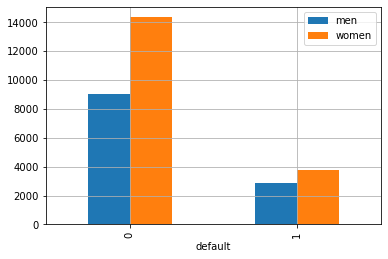

In [18]:
table_sex.plot.bar()
plt.legend(["men", "women"])
plt.grid()

Z-критерий для разности долей в независимых выборках

In [19]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [20]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [21]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [22]:
men_list = list(credit[credit.SEX == 1].default)
women_list = list(credit[credit.SEX == 2].default)

In [23]:
print("95%% confidence interval: [%f, %f]" %proportions_diff_confint_ind(men_list, women_list))
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(men_list, women_list)))

95% confidence interval: [0.024207, 0.043612]
p-value:  4.472866521609831e-12


In [96]:
nodef_sex = credit[credit['default'] == 0]['SEX']
def_sex = credit[credit['default'] == 1]['SEX']

In [99]:
proportions_diff_confint_ind(list(map(lambda x: 0 if x == 2 else x, nodef_sex)),
                             list(map(lambda x: 0 if x == 2 else x, def_sex)))

(-0.060548077974896725, -0.03363493274962867)

In [101]:
print("p-value: ", proportions_diff_z_test(proportions_diff_z_stat_ind(list(map(lambda x: 0 if x == 2 else x, nodef_sex)),
                                                                       list(map(lambda x: 0 if x == 2 else x, def_sex)))))

p-value:  4.472866521609831e-12


Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

In [102]:
credit.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [30]:
table_edu = credit.pivot_table(index='default',
                               values="LIMIT_BAL",
                               columns='EDUCATION',
                               aggfunc = len,
                               fill_value=0)
table_edu.head()

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


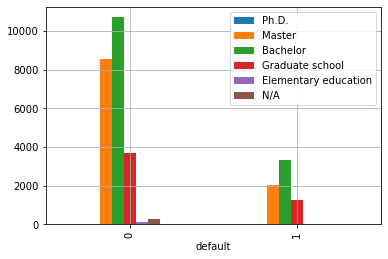

In [31]:
table_edu.plot.bar()
plt.legend(["Ph.D.", "Master", "Bachelor", "Graduate school", "Elementary education", "N/A"])
plt.grid()

Критерий хи-квадрат

In [32]:
chi2, pval, dof, ex = stats.chi2_contingency(table_edu.values)
print("chi2 contingency: %.4f, p-value: %s" % (chi2, pval))

chi2 contingency: 163.2166, p-value: 1.2332626245415605e-32


Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [107]:
credit.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [108]:
table_mar = credit.pivot_table(index='default',
                               values="LIMIT_BAL",
                               columns='MARRIAGE',
                               aggfunc = len,
                               fill_value=0)
table_mar.head()

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


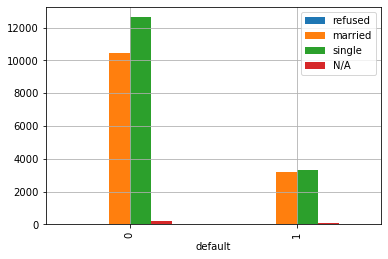

In [109]:
table_mar.plot.bar()
plt.legend(["refused", "married", "single", "N/A"])
plt.grid()

In [111]:
chi2, pval, dof, exp = stats.chi2_contingency(table_mar)

In [112]:
print("chi2 contingency: %.4f, p-value: %s" % (chi2, pval))

chi2 contingency: 35.6624, p-value: 8.825862457577375e-08


Коэффицент V Крамера

In [113]:
n = table_mar.sum(axis = 0).sum()
cr_v = (chi2 / n) ** 0.5
print('Cramer\'s V = %.4f' % cr_v)

Cramer's V = 0.0345


Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

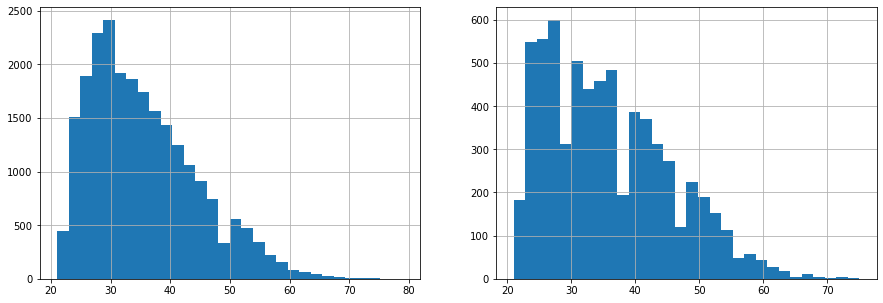

In [114]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
repayment.AGE.hist(bins=30)
plt.subplot(1,2,2)
loan.AGE.hist(bins=30)

In [115]:
print('Median LIMIT_BAL for default = 0: %.0f' % repayment.AGE.median())
print('Median LIMIT_BAL for default = 1: %.0f' % loan.AGE.median())

Median LIMIT_BAL for default = 0: 34
Median LIMIT_BAL for default = 1: 34


In [116]:
np.random.seed(123)

repayments_median = np.median(get_bootstrap_samples(repayment.AGE.values, 1000), axis=1)
loans_median = np.median(get_bootstrap_samples(loan.AGE.values, 1000), axis=1)

print("95% confidence interval for good clients:",  stat_intervals(repayments_median))
print("95% confidence interval for default clients:",  stat_intervals(loans_median))

95% confidence interval for good clients: [34. 34.]
95% confidence interval for default clients: [34. 35.]


In [117]:
delta_median = list(map(lambda x: x[1] - x[0], zip(loans_median, repayments_median)))

In [118]:
print("95% confidence interval for difference median:",  stat_intervals(delta_median, 0.05))

95% confidence interval for difference median: [-1.  0.]


Критерий Манна-Уитни

In [120]:
stats.mannwhitneyu(repayment.AGE.values, loan.AGE.values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)